### Written by Kevin Scaccia <kevin_developer@outlook.com>, Jan 2020

## Network Intrusion Detection - 93% Accuracy Model (KDD Cup 1999 Data)
#### Dense Autoencoder 
#### Data and Problem Description: https://www.kaggle.com/sampadab17/network-intrusion-detection
#### KDD Cup 1999 http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html




In [0]:
import numpy as np  # matrix math
import matplotlib.pyplot as plt  # plot library
import matplotlib.patches as mpatches  # legend on plot
import pandas as pd  # load dataset
from sklearn import datasets  # example dataset
from sklearn import metrics
import keras
from keras import models, layers
plt.style.use('ggplot') # plot style
#
from sklearn import preprocessing

### Load and Preproccess Data

In [2]:
full_data = pd.read_csv('Train_data.csv')
print(full_data.dtypes)

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

### Auxiliary Procedures

In [0]:
def plot_serie(serie, y='Y', x='Time', title='Plot', width=12, height=3):
    plt.figure(figsize=(width, height), dpi=80, facecolor='w');plt.grid(color='black', linestyle='-', linewidth=0.2)
    plt.ylabel(y); plt.xlabel(x); plt.plot(serie);plt.title(title);plt.show()
    print('----------------------------')
#
def preprocess_data(data, train_percent=0.8):
    # remove non-numeric features
    data = data.drop(['duration','protocol_type','service','flag'], axis=1)
    data_x = data.drop('class', axis=1).astype(float).values
    data_y = np.zeros(len(data))
    # label binarization
    for i, target in enumerate(data['class'].values):
        if target == 'anomaly':
            data_y[i] = 1.0
    #
    split_point = int(train_percent*len(data_x))
    train_x = data_x[:split_point]; train_y = data_y[:split_point]
    test_x = data_x[split_point:]; test_y = data_y[split_point:]
    # normalize features
    train_x, test_x = normalize_features(train_x, test_x)
    #
    return (train_x, train_y), (test_x, test_y)
#
#
#
def normalize_features(train_x, test_x):
    train_x = train_x.copy()
    test_x = test_x.copy()
    for feature_i in range(train_x.shape[1]):
        train_values = train_x[:,feature_i]
        test_values = test_x[:,feature_i]
        scaler = preprocessing.MinMaxScaler(feature_range=[0,1])
        train_values = scaler.fit_transform(train_values.reshape(-1, 1))
        test_values = scaler.transform(test_values.reshape(-1,1))
        #
        train_x[:, feature_i] = train_values.flatten()
        test_x[:, feature_i] = test_values.flatten()
    #
    return train_x, test_x
#
#
#
def plot_predictions(network_error, test_y, threshold, title='Anomaly Detection'):
    plt.figure(figsize=(14,4)); plt.title(title)
    plt.xlabel('Examples'); plt.ylabel('Network Error')
    plt.legend(handles=[mpatches.Patch(color='red', label='Anomaly'),
                        mpatches.Patch(color='blue', label='Normal'),
                        mpatches.Patch(color='green', label='Threshold = {}'.format(threshold))])
    for i in range(len(test_x)):
        if test_y[i] == 1: # anomaly
            color_plot = 'red'
        else: 
            color_plot = 'blue'
        plt.plot(i, network_error[i], color_plot, marker='o', ms=3.5, linestyle='',)
        #
    plt.axhline(y=threshold, linewidth=4, color='green')
    plt.show()

### Process Data

In [4]:
## train data
(train_x, train_y), (test_x, test_y) = preprocess_data(full_data)
print('train_x: {}, train_y: {}'.format(train_x.shape, train_y.shape))
print('test_x: {}, test_y: {}'.format(test_x.shape, test_y.shape))
## test data
num_features = train_x.shape[1]
print('{:.2} anomaly rate'.format((np.sum(train_y)/len(train_y))))

train_x: (20153, 37), train_y: (20153,)
test_x: (5039, 37), test_y: (5039,)
0.47 anomaly rate


In [5]:
train_only_normal = []
for i in range(len(train_x)):
    if train_y[i] == 0: # normal
        train_only_normal.append(train_x[i])
train_only_normal = np.array(train_only_normal)
print('total samples to train:', train_only_normal.shape[0])

total samples to train: 10773


In [0]:
for i in range(train_x.shape[1]):
    plot_serie(train_x[:,i])

### Define Model

In [42]:
autoencoder = models.Sequential()
autoencoder.add(layers.Dense(64, input_shape=(num_features,)))
autoencoder.add(layers.Dense(32))
autoencoder.add(layers.Dense(16))
autoencoder.add(layers.Dense(8))
autoencoder.add(layers.Dense(4))
autoencoder.add(layers.Dense(2))
autoencoder.add(layers.Dense(4))
autoencoder.add(layers.Dense(8))
autoencoder.add(layers.Dense(16))
autoencoder.add(layers.Dense(32))
autoencoder.add(layers.Dense(64))
autoencoder.add(layers.Dense(num_features)) # binary classification
autoencoder.compile(optimizer=keras.optimizers.adam(lr=0.01), loss='mse')
autoencoder.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 64)                2432      
_________________________________________________________________
dense_90 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_91 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_92 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_93 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_94 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_95 (Dense)             (None, 4)               

In [0]:
history = autoencoder.fit(train_only_normal, train_only_normal, epochs=500, batch_size=256)

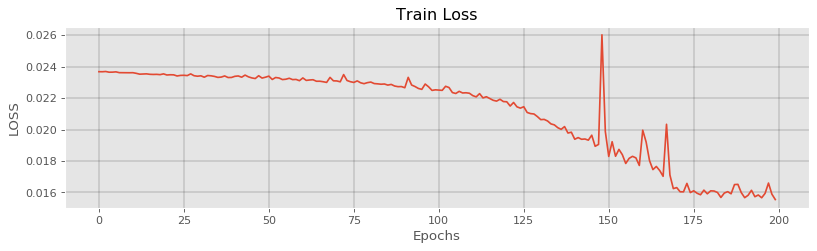

----------------------------


In [55]:
plot_serie(history.history['loss'][-200:], title='Train Loss', x='Epochs', y='LOSS')

### Predict

In [57]:
predictions_x = autoencoder.predict(test_x)
network_error = np.mean(np.power(test_x - predictions_x, 2), axis=1)
print('Predicted: ', network_error.shape)

Predicted:  (5039,)


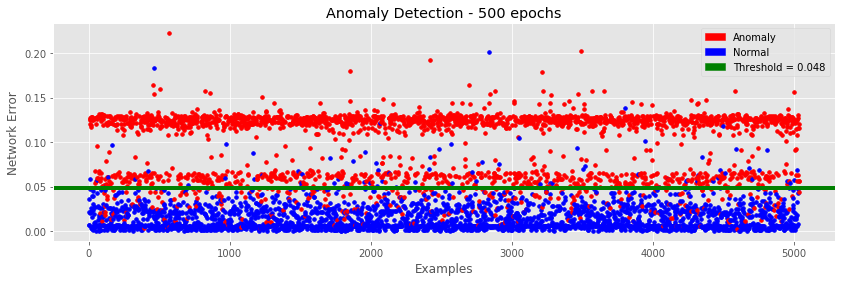

In [96]:
threshold = 0.048
plot_predictions(network_error, test_y, threshold, title='Anomaly Detection - 500 epochs')

### Model Evaluation

In [97]:
# classification
predictions_y = np.zeros((len(test_x)))
for i in range(len(test_x)):
    if network_error[i] >= threshold:
        predictions_y[i] = 1 # anomaly detected

# accuracy score
acc = metrics.accuracy_score(test_y, predictions_y)
print('Cassification Accuracy: {:.4}%'.format(acc*100))

Cassification Accuracy: 93.17%


In [98]:
# evaluate model
accuracy = metrics.accuracy_score(test_y, predictions_y)
confusion_matrix = metrics.confusion_matrix(test_y, predictions_y)
classification = metrics.classification_report(test_y, predictions_y)
#
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()

Model Accuracy:
 0.931732486604485

Confusion matrix:
 [[2594   82]
 [ 262 2101]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      2676
         1.0       0.96      0.89      0.92      2363

    accuracy                           0.93      5039
   macro avg       0.94      0.93      0.93      5039
weighted avg       0.93      0.93      0.93      5039


